In [1]:
use_gdrive = False

In [2]:
import os
from tqdm import tqdm

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/notebooks_data"
else:
  data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'
q2c_data_dir = data_dir + '/q2c_data'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(pretrained_models, exist_ok=True)
os.makedirs(q2c_data_dir, exist_ok=True)

mias_dataset_dir = datasets_dir + '/mias_dataset'
external_dataset_dir = datasets_dir + '/external_dataset'

In [10]:
# Download MIAS dataset
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/mias_dataset.zip -O {downloads_dir}/mias_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/external_dataset.zip -O {downloads_dir}/external_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/q2c_data.zip -O {downloads_dir}/q2c_data.zip

!unzip -o {downloads_dir}'/mias_dataset.zip' -d {mias_dataset_dir}
!unzip -o {downloads_dir}'/external_dataset.zip' -d {external_dataset_dir}
!unzip -o {downloads_dir}'/q2c_data.zip' -d {q2c_data_dir}

!rm -rf {downloads_dir}

!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/pretreained_models/instructors_model/model.pth -O {pretrained_models}/instructors_model.pth

Streaming output truncated to the last 5000 lines.
  inflating: ./data/datasets/mias_dataset/train/normal/A_0502_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0501_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0503_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0503_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0500_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0503_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0505_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0504_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0505_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0504_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0505_1.RIGHT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0504_1.RIGHT_CC.jpg  
 

This code was adapted from <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>


### Dependencies

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL
import random
from collections import defaultdict

# For reproducibility
torch.manual_seed(1234)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


First, we need to initialize an empty model, that will input an image, and output a classification. Each model is a little different, so we'll make a helper function that takes in an architecture name, and outputs a model. This is only meant as a guideline, and you can try using different models! `torchvision.models` has other common architectures, and variations on these (like ResNet-50 and ResNet-101), so you may want to try those out.

In [4]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")

    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))

    return model_ft, input_size

### Data Loading

With the input size from the model, we can now load the dataset

In [5]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.

    # We convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from the mean/stdev of the ImageNet training set which was used to pretrain our models.

    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(dataset_dir, input_size, batch_size, shuffle = True, transform=get_image_transforms()):
    data_transforms = {
        'train': transform,
        'val': transform,
        'test': transform
    }
    # Create training, validation and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training, validation and test dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

### Training
Next, let's make a helper function that trains the given model

In [6]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found,
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

### Optimizer & Loss
We need a loss function, and an optimization function to use to try to reduce that loss.

In [7]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)


    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

### Parameters

Our data is conveniently set up to follow the expected format of the  `ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset class, rather than writing our own custom dataset.

The ``model_name`` input is the name of the model you wish to use. We've provided starter code that initializes these models using provided models in TorchVision (a PyTorch library)

The code as is supports the following values: [resnet, alexnet, vgg, squeezenet, densenet]


In [8]:
model_name = 'densenet'

# Number of classes in the dataset, normal, benign, malignant
num_classes = 3

batch_size = 16
shuffle_datasets = True
num_epochs = 20
learning_rate = 0.001

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k
pretrained = False

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)

### Training

In [11]:
# Initialize the model for this run
# train model_1
model_1, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
criterion = get_loss()

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

# Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1,
                                                                     dataloaders=dataloaders,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer_1,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs)
del model_1, optimizer_1, trained_model_1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.4789 Acc: 0.8673


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.4073 Acc: 0.8812

Epoch 2/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.4192 Acc: 0.8709


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3799 Acc: 0.8812

Epoch 3/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.3219 Acc: 0.8766


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.8120 Acc: 0.7030

Epoch 4/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.3164 Acc: 0.8864


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.2741 Acc: 0.8845

Epoch 5/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.2029 Acc: 0.9184


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 3.7595 Acc: 0.2046

Epoch 6/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1459 Acc: 0.9371


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1352 Acc: 0.9538

Epoch 7/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1755 Acc: 0.9269


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.4981 Acc: 0.8152

Epoch 8/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1510 Acc: 0.9412


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.8728 Acc: 0.7558

Epoch 9/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1595 Acc: 0.9379


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.5538 Acc: 0.4752

Epoch 10/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1257 Acc: 0.9472


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 6.1176 Acc: 0.1485

Epoch 11/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1138 Acc: 0.9501


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.2059 Acc: 0.9340

Epoch 12/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1109 Acc: 0.9485


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.5714 Acc: 0.8746

Epoch 13/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1558 Acc: 0.9379


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 8.3931 Acc: 0.0759

Epoch 14/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1001 Acc: 0.9533


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3602 Acc: 0.8977

Epoch 15/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0882 Acc: 0.9529


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 6.4666 Acc: 0.2145

Epoch 16/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0828 Acc: 0.9554


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.0472 Acc: 0.7162

Epoch 17/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.2399 Acc: 0.9184


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.8313 Acc: 0.4389

Epoch 18/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1782 Acc: 0.9265


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 3.5496 Acc: 0.1683

Epoch 19/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1517 Acc: 0.9343


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.3447 Acc: 0.8812

Epoch 20/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1273 Acc: 0.9460


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 3.4151 Acc: 0.2805

Training complete in 9m 53s
Best val Acc: 0.953795


### Load trained models

In [12]:
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'
model_yours, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)


model_yours = model_yours.to(device)
model_yours.load_state_dict(torch.load(weights_file))

model_inst = torch.load(pretrained_models + '/instructors_model.pth')
model_inst = model_inst.to(device)

# set models to eval mode
model_yours = model_yours.eval()
model_inst = model_inst.eval()



Now that we've trained a model, we would like to use it for inference on the test data.
We will use a function that can compute top-k performance (k = 1)


In [13]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1)
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None

    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels

In [14]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_yours, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_yours, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

val_loss_inst, val_top1_inst, _, val_labels_inst = evaluate(model_inst, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_inst, test_top1_inst, _, test_labels_inst = evaluate(model_inst, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

print("Instructors model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_inst))
print("Test Top-1 Accuracy: {}".format(test_top1_inst))

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Your Trained model: 
Val Top-1 Accuracy: 0.9537953795379538
Test Top-1 Accuracy: 0.9444444444444444
Instructors model: 
Val Top-1 Accuracy: 0.9636963696369637
Test Top-1 Accuracy: 0.9477124183006537


In [15]:
model = model_inst
# model = model_yours

In [16]:
# Wrapper to easily evaulate a model given a model and the set of dataloaders
def get_eval_results(model, dataloaders):
    model.eval()
    true_label_list = []
    outputs_list = []
    predicted_label_list = []
    original_image_list = []

    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            true_label_list.append(labels)
            original_image_list.append(inputs)
            outputs_list.append(outputs)
            _, preds = torch.topk(outputs, k=1, dim=1)
            predicted_label_list.append(preds)
    return torch.concat(true_label_list).unsqueeze(-1).cpu().numpy(), \
           torch.concat(predicted_label_list).cpu().numpy(), \
           torch.softmax(torch.concat(outputs_list), dim=1).cpu().numpy(), \
           torch.concat(original_image_list).cpu().numpy()

## Please make sure you understand what outputs means here
y_label, y_pred, outputs, inputs =  get_eval_results(model, dataloaders)

  0%|          | 0/20 [00:00<?, ?it/s]


Confusion Matrix

The first simple method that we will use to delve deeper into the results is the confusion matrix. Complete the function below and plot your confusion matrix.


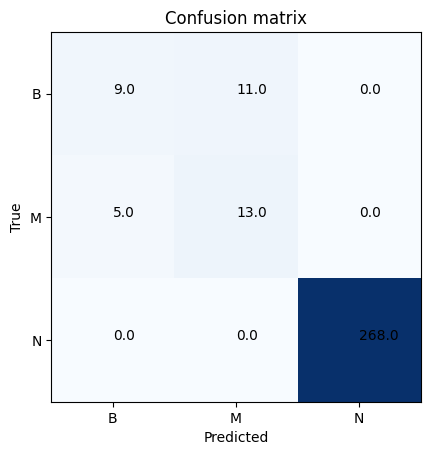

In [17]:
### Complete your code here to plot your confusion matrix.
### Please avoid using sklearn.metrics.confusion_matrix in your function: build your confusion matrix from scratch! You may, however, want to plot its output to check if you're doing the right thing!
### Using helper visualization functions is fine, but don't leave the numbers themselves to sub-packages.
### Feel free to import necessary packages.

def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    n = np.unique(y_label).shape[0]
    matrix = np.zeros((n, n))

    # Get numbers from labels
    for i in range(len(y_label)):
        true_label = y_label[i]
        pred_label = y_pred[i]
        matrix[true_label, pred_label] += 1

    # Plot
    plt.imshow(matrix, cmap=plt.cm.Blues)

    # Numbers
    for i in range(n):
        for j in range(n):
            plt.text(j, i, format(matrix[i, j]), color="black")

    # Labels
    plt.xticks(np.arange(n), ['B', 'M', 'N'])
    plt.yticks(np.arange(n), ['B', 'M', 'N'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

plot_confusion_matrix(y_label, y_pred)

Precision-Recall Curve

Assume that the malignant class is our positive class, and the rest are negative classes. In this scenario, a positive prediction happens when our model's prediction for class malignant is *above a user-defined threshold*. That means that a True Positive (TP) happens when we have a positive prediction and the ground truth label is malignant. A False Positive (FP) happens when we have a positive prediction and the ground truth label is something other than malignant. True negatives (TN) and false negatives (FN) follow the same logic.

Remember that Precision = TP/(TP+FP) and Recall = TP/(TP+FN).




Text(0.5, 1.0, 'Recall Precision Curve')

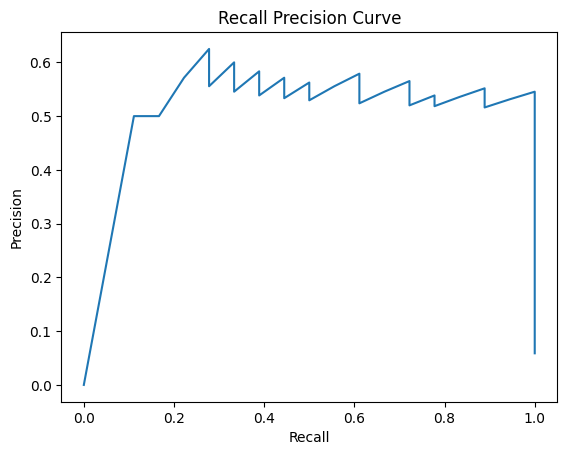

In [18]:
new_labels = []
threshold_values = np.linspace(0, 1, 1001)  # 1000 vals

# Create new labels
new_labels = np.array([
    0 if (isinstance(label, np.ndarray) and label[0] in [0, 2]) else 1
    for label in y_label
])

# Initialize recalls and precisions
recalls, precisions = [], []

for threshold_value in threshold_values:
    binary_predictions = (outputs[:, 1] >= threshold_value)
    t_pos = np.sum(binary_predictions * new_labels)
    f_pos = np.sum(binary_predictions * (1 - new_labels))
    f_neg = np.sum((1 - binary_predictions) * new_labels)

    recalls.append(t_pos / (t_pos + f_neg))
    precisions.append(t_pos / (t_pos + f_pos + 1e-100))

# Plot the recall vs precision curve
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall Precision Curve")

In the following code snippet, we use the following pytorch package that implements different variations of CAM:
https://github.com/jacobgil/pytorch-grad-cam


In [19]:
!pip install grad-cam

import random
from collections import defaultdict

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [29]:
def plot_cams(target_dataloaders, cam_method=GradCAM, class_id='gt'):
  assert class_id in ['gt', 'pred'] or type(class_id) is int and class_id < 3
  for split in ['train', 'val', 'test']:
    target_layers = [model.layer4[-1]]
    fig, axs = plt.subplots(2, 6, figsize=(14, 7))
    fig.suptitle("Examples split {}, class {}".format(split, class_id), fontsize=16)

    split_dataset = target_dataloaders[split].dataset
    indices_per_class = defaultdict(list)
    for i, (_, c) in enumerate(split_dataset.imgs):
      indices_per_class[c].append(i)

    random.seed(1337)
    indices = []
    for c in range(3):
      indices.extend(random.sample(indices_per_class[c], 4))

    for dataset_i, ax in zip(indices, axs.flatten()):
      input_tensor, class_idx = split_dataset[dataset_i]
      input_tensor = input_tensor[None,...].cuda()

      # Construct the CAM object once, and then re-use it on many images:
      cam = cam_method(model=model, target_layers=target_layers)
      pred_class_idx = model(input_tensor).argmax()

      # We have to specify the target we want to generate
      # the Class Activation Maps for
      if type(class_id) is int:
        target_class_id = class_id
      else:
        target_class_id = pred_class_idx if class_id == 'pred' else class_idx
      targets = [ClassifierOutputTarget(target_class_id)]

      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam = grayscale_cam[0, :]
      rgb_image = np.array(input_tensor[0].cpu())
      rgb_image = (rgb_image - rgb_image.min())/ (rgb_image.max() - rgb_image.min())
      visualization = show_cam_on_image(rgb_image.transpose((1,2,0)), grayscale_cam, use_rgb=True)

      ax.set_title('True : %s\n Predicted: %s' %(split_dataset.classes[class_idx], split_dataset.classes[pred_class_idx]))
      ax.imshow(visualization)


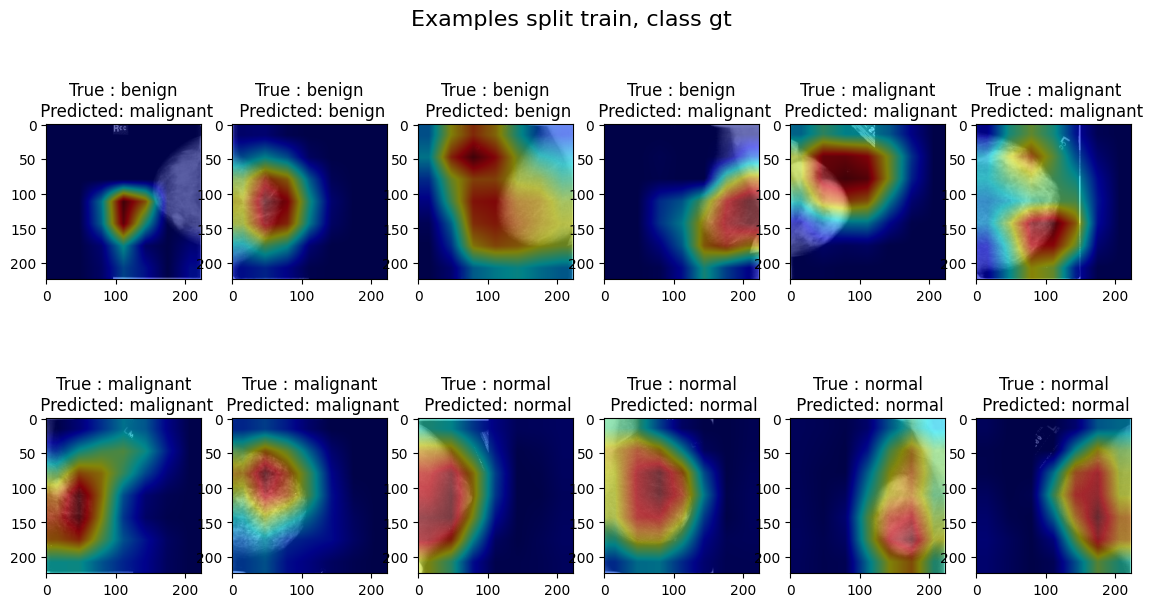

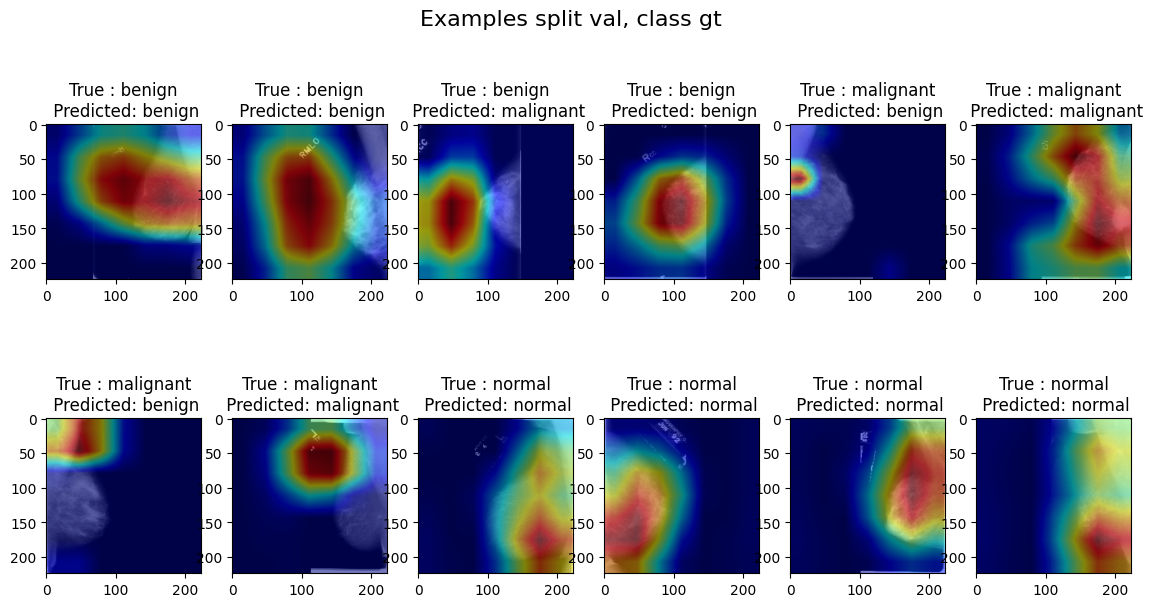

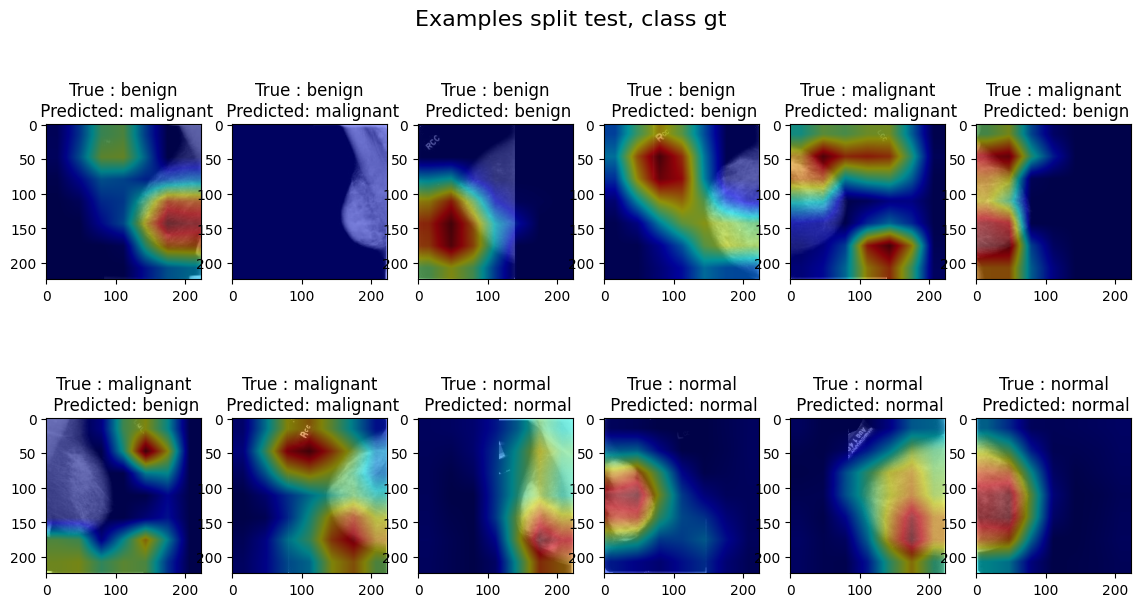

In [30]:
# GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# Also substitute class_id for pred, or a class id in [0,1,2] to check different output.
plot_cams(dataloaders, cam_method=GradCAM, class_id='gt')